# Training a MNIST CLASSIFIER using custom made libray

The following notebook goes through an example of MNIST training using only numpy, and standard python packages. Visit the GitLab repo for insights on the code. Final accuracy achieved on test set ~97%

In [1]:
# import python packages
import modules
import utils
import numpy as np
from PIL import Image
import random
from modules import *

In [2]:
# import MNIST data, preprocess it (normalize and reshape) and organize it in training and test sets
from mnist import MNIST
mndata = MNIST('./MNIST_data')
images, labels = mndata.load_training()
images, labels = np.array(images)/255, np.array(labels).reshape(-1,1)
images = images.reshape(images.shape[0],-1,28,28)
train_data = list(zip(images, labels))
random.shuffle(train_data)

N = labels.shape[0]
print("\nwe have {} train samples.".format(N))

images, labels = mndata.load_testing()
images, labels = np.array(images)/255, np.array(labels).reshape(-1,1)
images = images.reshape(images.shape[0],-1,28,28)
test_data = list(zip(images, labels))

N = labels.shape[0]
print("\nwe have {} test samples.\n\n".format(N))


we have 60000 train samples.

we have 10000 test samples.




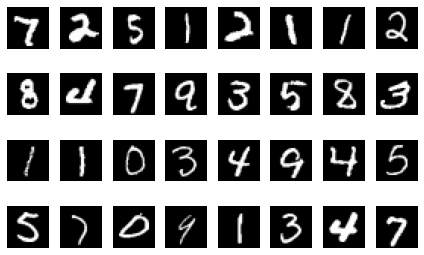

In [3]:
# helper functions to batch data
def get_random_train_batch(B = 32):
    idxs = np.random.randint(len(labels), size=(B,))
    return images[idxs, ...], labels[idxs, ...]

# generator function to loop through batches of data
def batch_data(data, B=32):
    l = len(data)
    for ndx in range(0, l, B):
        img, lbl = zip(*data[ndx:min(ndx + B, l)])
        img = np.expand_dims(np.concatenate(img, axis = 0), axis=1)
        lbl = np.concatenate(lbl, axis = 0)
        yield img, lbl

utils.show_batch_of_tensors(get_random_train_batch()[0], ncol=8)

In [4]:
# define a simple CNN using our custom library (coded to be similar to pytorch, even though interface is quite untidy)
# as long as you only use legal Modules you dont have to specify the backward function, see repo for code)
class Net(Module):
    def __repr__(self):
        _name = "Custom Network\n"
        for _, module in self.submodules():
            _name+=module.__repr__()
        return _name
    
    def __init__(self):
        super(Net, self).__init__()
        self.add_module("conv1", modules.Conv2D(in_channels=1,
                                                out_channels=4,
                                                kernel_size=(3,3),
                                                padding=1,
                                                stride=2))
        
        self.add_module("relu1", modules.ReLU())
        
        self.add_module("conv2", modules.Conv2D(in_channels=4,
                                                out_channels=8,
                                                kernel_size=(3,3),
                                                padding=1,
                                                stride=2))
        self.add_module("relu2", modules.ReLU())
        
        self.add_module("conv3", modules.Conv2D(in_channels=8,
                                        out_channels=16,
                                        kernel_size=(4,4),
                                        padding=0,
                                        stride=1))
        self.add_module("relu3", modules.ReLU())
        
        self.add_module("view", modules.View(shape=(-1, 16*4*4)))
        
        self.add_module("linear", modules.Linear(16*4*4, 10))
        
        self.add_module("softmax", modules.Softmax())
        
        self.add_module("NLL", modules.NegativeLogLikelyhood())
        
    
    def forward(self, inputs, labels):
        out = self._modules['relu1'](self._modules['conv1'](inputs))
        out = self._modules['relu2'](self._modules['conv2'](out))
        out = self._modules['relu3'](self._modules['conv3'](out))
        out = self._modules['view'](out)
        out = self._modules['linear'](out)
        out = self._modules['softmax'](out)
        loss = self._modules['NLL'](out, labels)
        return out, loss   

In [5]:
# train for a few epochs (code may not be that efficient, on my laptop it takes a couple of minutes)
model = Net()
print(model)

# some hyper params
max_epochs = 2
batch_size = 32
learning_rate = 0.001

# train
model.train() #activates gradients
for epoch in range(1,max_epochs+1):
    for idx, (img, lbl) in enumerate(batch_data(train_data, batch_size)):
        model.zero_grad()
        out, loss = model(img, lbl)
        model.update_params(lr = learning_rate)
        if idx%500 == 0:
            print("epoch {} ({:.2f}%)\t loss: {:.6f}".format(epoch,
                                                             int(idx/(len(train_data)//batch_size)*100),
                                                             loss.item()))
        
# test
model.eval() # deactivate gradients
correct = 0
total = len(test_data)
for idx, (img, lbl) in enumerate(batch_data(test_data, batch_size)):
    out, loss = model(img, lbl)
    pred = out.argmax(axis=1)
    correct += sum(pred == lbl)
    if idx%25 == 0:
        print("testing ({:.2f}%)\t loss: {:.6f}".format(int(idx/(total//batch_size)*100),
                                                        loss.item()))

print("\nfinal accuracy: {}/{} ({:.2f})%".format(correct, total, correct/total*100))







Custom Network
Conv2D layer
	weight	(4, 1, 3, 3)
	bias	(4, 1)
ReLU activation
Conv2D layer
	weight	(8, 4, 3, 3)
	bias	(8, 1)
ReLU activation
Conv2D layer
	weight	(16, 8, 4, 4)
	bias	(16, 1)
ReLU activation
View tensor
Linear layer
	weight	(256, 10)
	bias	(10,)
Softmax activation
Negative Log-Likelyhood loss

epoch 1 (0.00%)	 loss: 2.294152
epoch 1 (26.00%)	 loss: 0.733713
epoch 1 (53.00%)	 loss: 0.189911
epoch 1 (80.00%)	 loss: 0.281807
epoch 2 (0.00%)	 loss: 0.136327
epoch 2 (26.00%)	 loss: 0.502724
epoch 2 (53.00%)	 loss: 0.195970
epoch 2 (80.00%)	 loss: 0.228152
testing (0.00%)	 loss: 0.009938
testing (8.00%)	 loss: 0.031366
testing (16.00%)	 loss: 0.352841
testing (24.00%)	 loss: 0.186545
testing (32.00%)	 loss: 0.081662
testing (40.00%)	 loss: 0.023891
testing (48.00%)	 loss: 0.244287
testing (56.00%)	 loss: 0.118075
testing (64.00%)	 loss: 0.074777
testing (72.00%)	 loss: 0.111650
testing (80.00%)	 loss: 0.022144
testing (88.00%)	 loss: 0.002168
testing (96.00%)	 loss: 0.040830

